# Unsupervised Analysis: Degradation Effects in Histogram-PCA Feature Space

This notebook analyzes how image degradations affect the histogram-PCA feature space used by the SVM classifier.

**Key insight**: The SVM operates in a space of PCA-transformed 32-bin HSV histogram features. This analysis examines:
- Whether clean and degraded samples cluster together or apart
- How different degradation types (dirty, bruised, blur, dark, overexposed) manifest in feature space
- Connection between feature space geometry and robustness performance

## Setup: Imports and Constants

In [8]:
import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

OUTPUT_DIR = "report_assets/unsupervised_analysis"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
TABLE_DIR = os.path.join(OUTPUT_DIR, "tables")
CACHE_DIR = os.path.join(OUTPUT_DIR, "cache")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

HIST_BINS = 32
IMG_SIZE = 32

def save_fig(name):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved {path}")

def save_table(df, name):
    csv_path = os.path.join(TABLE_DIR, name + ".csv")
    md_path = os.path.join(TABLE_DIR, name + ".md")
    df.to_csv(csv_path, index=False)
    try:
        df.to_markdown(md_path, index=False)
    except Exception:
        df.to_csv(md_path, index=False)
    print(f"Saved {csv_path}")
    print(f"Saved {md_path}")

## 1. Dataset Loading and Degradation Functions

In [9]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []

        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label = class_name if self.variety else class_name.split()[0]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))

        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}

        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label_str

transform_32 = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform_32, variety=False)

Test: 43442 images, 79 classes


## 2. Degradation Functions

In [10]:
def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3, 1, 1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3, 1, 1)
blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def dark_strong(x):
    return clamp_01(x * 0.5)

def overexposed_strong(x):
    return clamp_01(x * 1.5)

def dirty(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def blur(x):
    return blur_medium(x)

def dark(x):
    return dark_strong(x)

def overexposed(x):
    return overexposed_strong(x)

degradation_funcs = {
    "clean": lambda x: x,
    "dirty": dirty,
    "bruised": bruised,
    "blur": blur,
    "dark": dark,
    "overexposed": overexposed,
}

## 3. Histogram-PCA Feature Extraction

In [11]:
def color_hist_features(X, bins=HIST_BINS, img_shape=(3, IMG_SIZE, IMG_SIZE)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

scaler = joblib.load("saved_models/scaler_augmented_colorhist32bins_32x32_stacking.joblib")
pca_model = joblib.load("saved_models/pca_augmented_colorhist32bins_32x32_stacking.joblib")

print(f"Scaler features: {scaler.n_features_in_}")
print(f"PCA components: {pca_model.n_components_}")

def get_histogram_pca_features(imgs_tensor):
    X = imgs_tensor.numpy()
    X_hist = color_hist_features(X, bins=HIST_BINS, img_shape=(3, IMG_SIZE, IMG_SIZE))
    X_scaled = scaler.transform(X_hist)
    X_pca = pca_model.transform(X_scaled)
    return X_pca

Scaler features: 96
PCA components: 43


## 4. Build Per-Class Mini-Datasets (Clean + Degraded)

In [12]:
SELECTED_CLASSES = ["Apple", "Banana", "Lemon"]
DEGRADATIONS = ["clean", "dirty", "bruised", "blur", "dark", "overexposed"]
N_CLEAN_PER_CLASS = 150

def build_class_dataset(class_name, n_samples=N_CLEAN_PER_CLASS):
    paths = [p for p, lbl in test_dataset.samples if lbl == class_name]
    if len(paths) < n_samples:
        print(f"Warning: only {len(paths)} samples for {class_name}, requested {n_samples}")
        n_samples = len(paths)
    
    rng = np.random.default_rng(RANDOM_STATE)
    selected_paths = rng.choice(paths, size=n_samples, replace=False)
    
    data_records = []
    
    print(f"Processing {class_name}...")
    for i, path in enumerate(selected_paths):
        if (i + 1) % 30 == 0:
            print(f"  {i + 1}/{n_samples}")
        
        img_pil = Image.open(path).convert("RGB")
        img_tensor = transform_32(img_pil)
        
        for deg_type in DEGRADATIONS:
            np.random.seed(RANDOM_STATE + i)
            torch.manual_seed(RANDOM_STATE + i)
            
            deg_func = degradation_funcs[deg_type]
            img_deg = deg_func(img_tensor.clone())
            
            X_pca = get_histogram_pca_features(img_deg.unsqueeze(0))
            
            data_records.append({
                "class_label": class_name,
                "deg_type": deg_type,
                "features": X_pca[0],
                "img_path": path,
            })
    
    print(f"Done: {len(data_records)} samples for {class_name}")
    return data_records

all_data = []
for cls in SELECTED_CLASSES:
    records = build_class_dataset(cls, n_samples=N_CLEAN_PER_CLASS)
    all_data.extend(records)

print(f"\nTotal samples: {len(all_data)}")

Processing Apple...
  30/150
  60/150
  90/150
  120/150
  150/150
Done: 900 samples for Apple
Processing Banana...
  30/150
  60/150
  90/150
  120/150
  150/150
Done: 900 samples for Banana
Processing Lemon...
  30/150
  60/150
  90/150
  120/150
  150/150
Done: 900 samples for Lemon

Total samples: 2700


## 5. 2D Visualization: PCA Projections

Saved report_assets/unsupervised_analysis/figures/fig_unsup_pca2d_apple.png


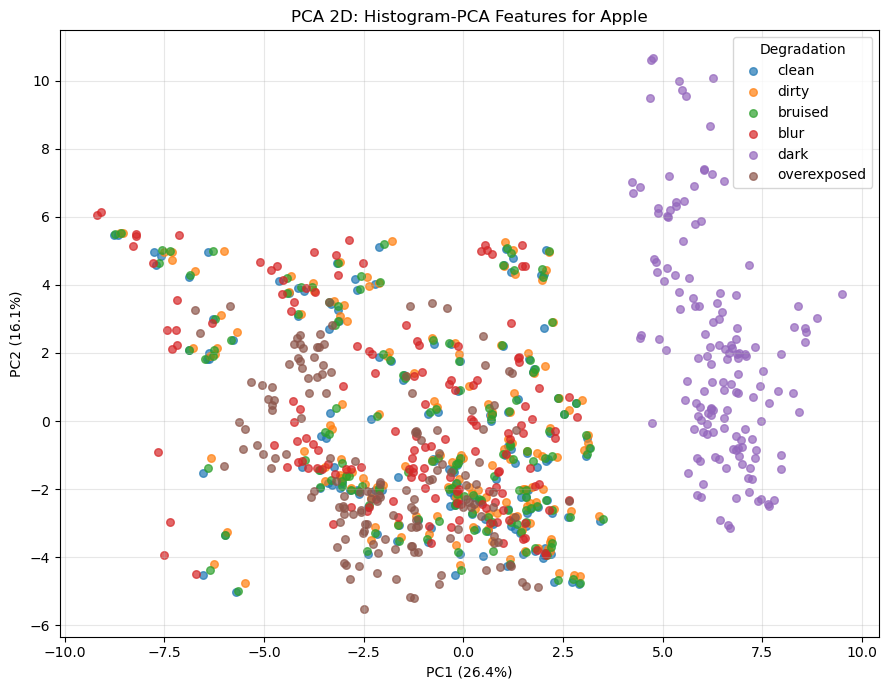

Saved report_assets/unsupervised_analysis/figures/fig_unsup_pca2d_banana.png


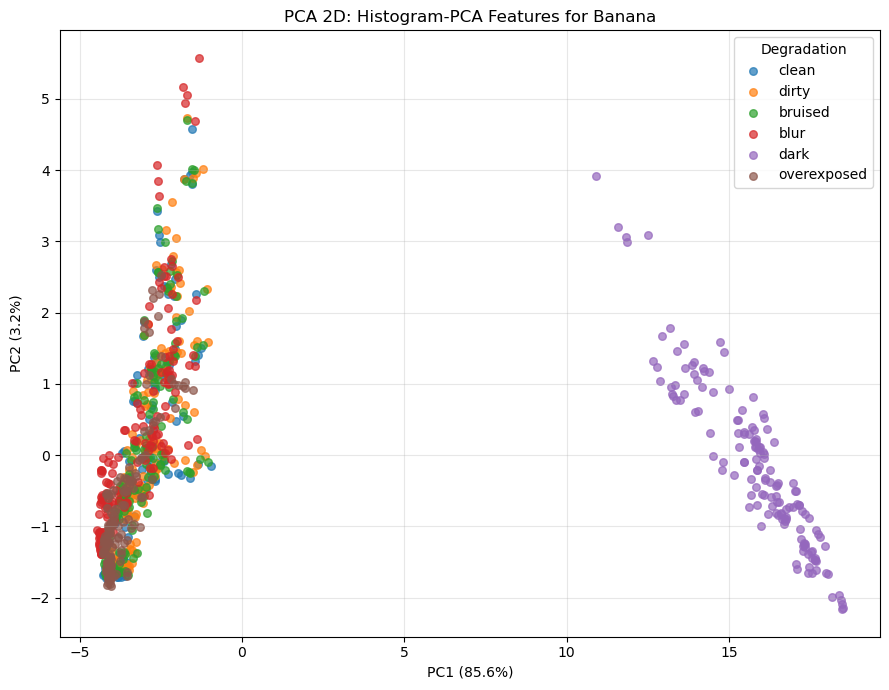

Saved report_assets/unsupervised_analysis/figures/fig_unsup_pca2d_lemon.png


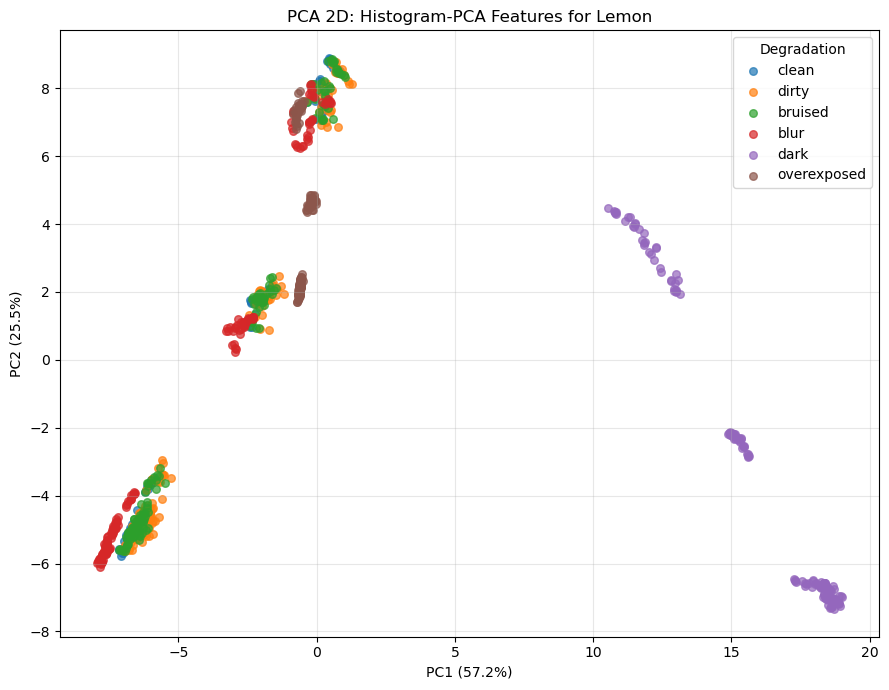

In [13]:
def plot_2d_pca_by_class(all_data, class_name, degradations):
    class_data = [d for d in all_data if d["class_label"] == class_name]
    
    X = np.stack([d["features"] for d in class_data], axis=0)
    y_deg = np.array([d["deg_type"] for d in class_data])
    
    pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
    X_2d = pca_2d.fit_transform(X)
    
    color_map = {
        "clean": "#1f77b4",
        "dirty": "#ff7f0e",
        "bruised": "#2ca02c",
        "blur": "#d62728",
        "dark": "#9467bd",
        "overexposed": "#8c564b",
    }
    
    fig, ax = plt.subplots(figsize=(9, 7))
    for deg in degradations:
        idx = y_deg == deg
        ax.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            label=deg,
            alpha=0.7,
            s=30,
            color=color_map.get(deg, "gray"),
        )
    
    ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})")
    ax.set_title(f"PCA 2D: Histogram-PCA Features for {class_name}")
    ax.legend(title="Degradation", loc="best")
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    filename = f"fig_unsup_pca2d_{class_name.lower()}.png"
    save_fig(filename)
    plt.show()
    
    return X_2d, y_deg

pca2d_results = {}
for cls in SELECTED_CLASSES:
    X_2d, y_deg = plot_2d_pca_by_class(all_data, cls, DEGRADATIONS)
    pca2d_results[cls] = (X_2d, y_deg)

## 6. 2D Visualization: t-SNE Projections

Running t-SNE for Apple...
Saved report_assets/unsupervised_analysis/figures/fig_unsup_tsne_apple.png


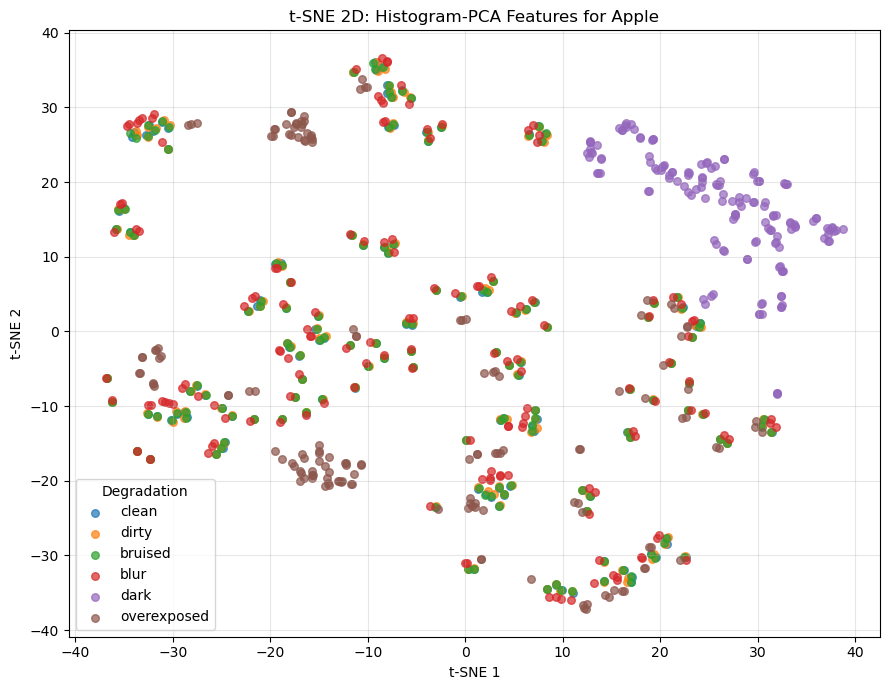

Running t-SNE for Banana...
Saved report_assets/unsupervised_analysis/figures/fig_unsup_tsne_banana.png


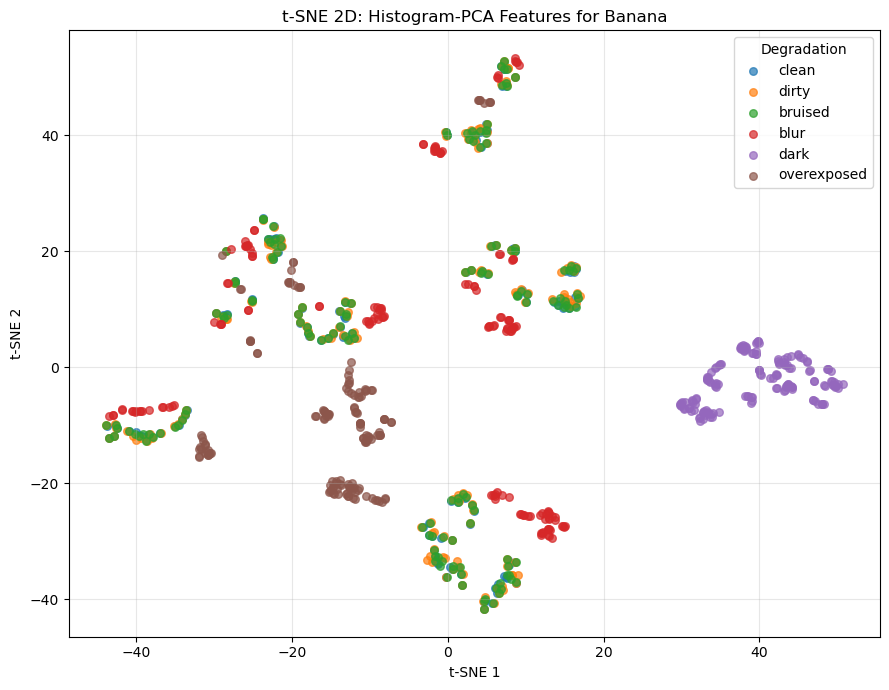

Running t-SNE for Lemon...
Saved report_assets/unsupervised_analysis/figures/fig_unsup_tsne_lemon.png


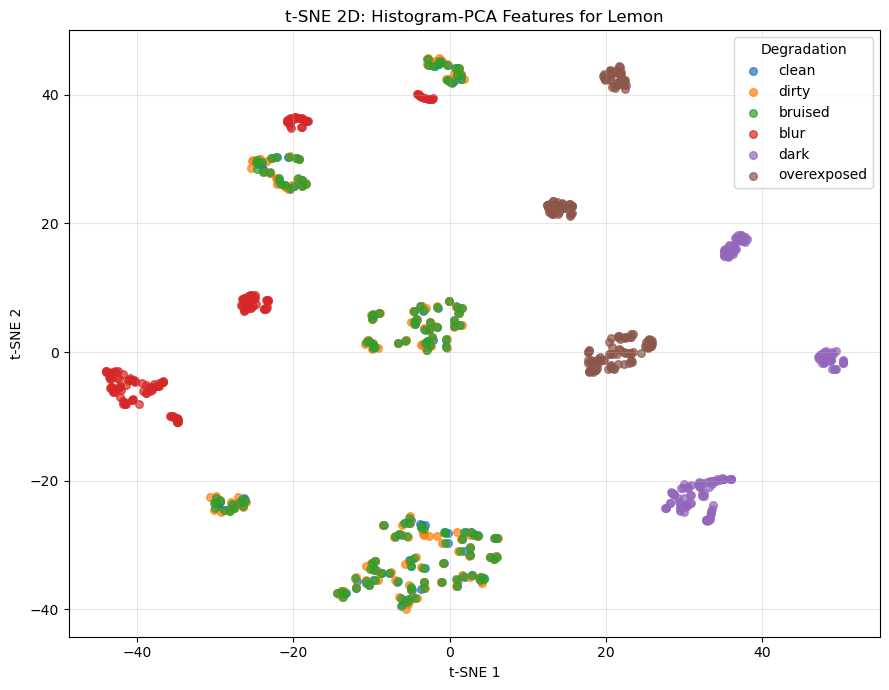

In [14]:
def plot_2d_tsne_by_class(all_data, class_name, degradations):
    class_data = [d for d in all_data if d["class_label"] == class_name]
    
    X = np.stack([d["features"] for d in class_data], axis=0)
    y_deg = np.array([d["deg_type"] for d in class_data])
    
    print(f"Running t-SNE for {class_name}...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(X)
    
    color_map = {
        "clean": "#1f77b4",
        "dirty": "#ff7f0e",
        "bruised": "#2ca02c",
        "blur": "#d62728",
        "dark": "#9467bd",
        "overexposed": "#8c564b",
    }
    
    fig, ax = plt.subplots(figsize=(9, 7))
    for deg in degradations:
        idx = y_deg == deg
        ax.scatter(
            X_tsne[idx, 0],
            X_tsne[idx, 1],
            label=deg,
            alpha=0.7,
            s=30,
            color=color_map.get(deg, "gray"),
        )
    
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_title(f"t-SNE 2D: Histogram-PCA Features for {class_name}")
    ax.legend(title="Degradation", loc="best")
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    filename = f"fig_unsup_tsne_{class_name.lower()}.png"
    save_fig(filename)
    plt.show()
    
    return X_tsne, y_deg

tsne_results = {}
for cls in SELECTED_CLASSES:
    X_tsne, y_deg = plot_2d_tsne_by_class(all_data, cls, DEGRADATIONS)
    tsne_results[cls] = (X_tsne, y_deg)

## 7. K-Means Clustering by Degradation Type

In [15]:
def kmeans_analysis_by_class(all_data, class_name, degradations, n_clusters):
    class_data = [d for d in all_data if d["class_label"] == class_name]
    
    X = np.stack([d["features"] for d in class_data], axis=0)
    y_deg = np.array([d["deg_type"] for d in class_data])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    cluster_ids = kmeans.fit_predict(X)
    
    silhouette = silhouette_score(X, cluster_ids)
    
    contingency = pd.DataFrame()
    for c_id in range(n_clusters):
        row = {}
        mask = cluster_ids == c_id
        for deg in degradations:
            count = np.sum((y_deg == deg) & mask)
            row[deg] = count
        contingency = pd.concat([contingency, pd.DataFrame([row])], ignore_index=True)
    
    contingency["cluster_id"] = range(n_clusters)
    contingency = contingency[["cluster_id"] + degradations]
    contingency["total"] = contingency[degradations].sum(axis=1)
    
    contingency_norm = contingency.copy()
    for deg in degradations:
        contingency_norm[f"{deg}_pct"] = (
            100.0 * contingency_norm[deg] / contingency_norm["total"]
        ).round(1)
    
    return {
        "cluster_ids": cluster_ids,
        "silhouette": silhouette,
        "contingency": contingency,
        "contingency_norm": contingency_norm,
        "kmeans": kmeans,
        "X": X,
        "X_2d": pca2d_results.get(class_name, (None, None))[0],
    }

kmeans_results = {}
for cls in SELECTED_CLASSES:
    results = kmeans_analysis_by_class(all_data, cls, DEGRADATIONS, n_clusters=len(DEGRADATIONS))
    kmeans_results[cls] = results
    print(f"\n{cls} - K-Means Analysis:")
    print(f"Silhouette Score: {results['silhouette']:.4f}")
    print(f"Contingency Table:\n{results['contingency']}")


Apple - K-Means Analysis:
Silhouette Score: 0.1694
Contingency Table:
   cluster_id  clean  dirty  bruised  blur  dark  overexposed  total
0           0      0      0        0     0    75            0     75
1           1     41     41       41    45     0           39    207
2           2     19     19       19    19     6           14     96
3           3     58     58       58    54     0           64    292
4           4      5      5        5     5    69            0     89
5           5     27     27       27    27     0           33    141

Banana - K-Means Analysis:
Silhouette Score: 0.2504
Contingency Table:
   cluster_id  clean  dirty  bruised  blur  dark  overexposed  total
0           0      0      0        0     0    69            0     69
1           1     43     43       43    45     0           19    193
2           2     58     57       57    56     0          122    350
3           3     28     29       29    28     0            1    115
4           4     21     21  

## 8. K-Means Cluster Visualization (in 2D PCA space)

Saved report_assets/unsupervised_analysis/figures/fig_unsup_kmeans_2d_apple.png


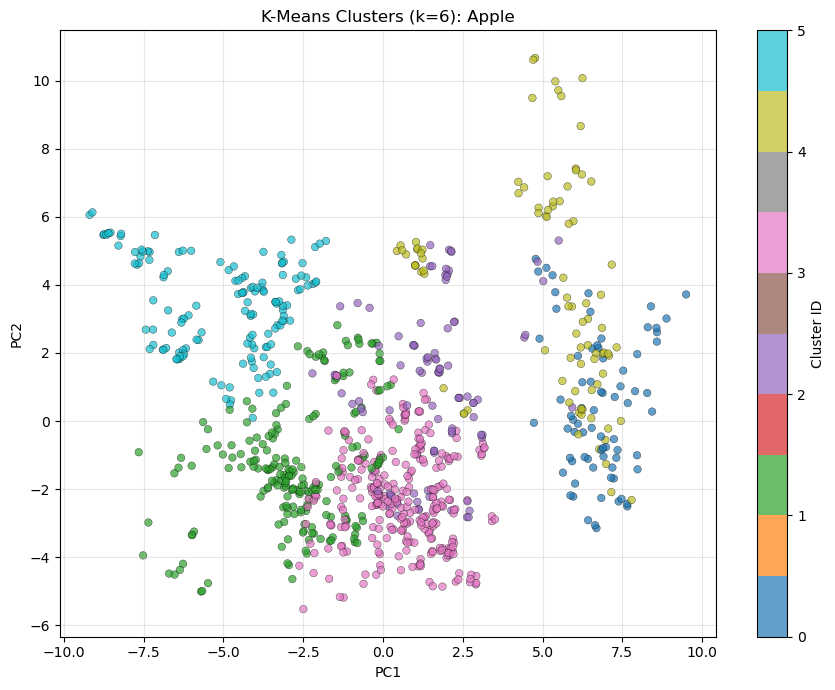

Saved report_assets/unsupervised_analysis/figures/fig_unsup_kmeans_2d_banana.png


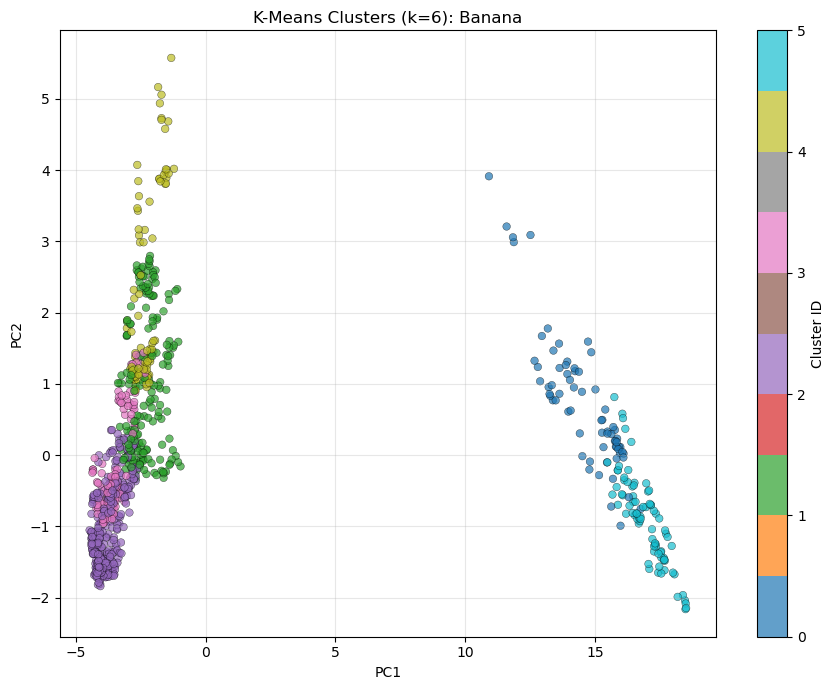

Saved report_assets/unsupervised_analysis/figures/fig_unsup_kmeans_2d_lemon.png


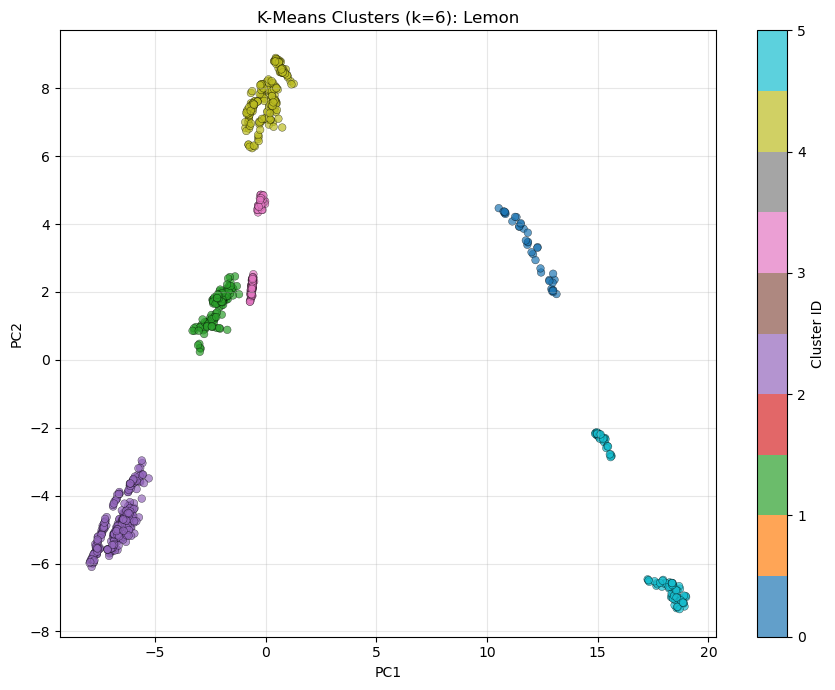

In [16]:
def plot_kmeans_clusters_2d(class_name, kmeans_results):
    result = kmeans_results[class_name]
    X_2d = result["X_2d"]
    cluster_ids = result["cluster_ids"]
    
    if X_2d is None:
        print(f"Skipping {class_name}: no 2D projection available")
        return
    
    fig, ax = plt.subplots(figsize=(9, 7))
    
    scatter = ax.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=cluster_ids,
        cmap="tab10",
        s=30,
        alpha=0.7,
        edgecolors="k",
        linewidth=0.3,
    )
    
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"K-Means Clusters (k={len(DEGRADATIONS)}): {class_name}")
    plt.colorbar(scatter, ax=ax, label="Cluster ID")
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    filename = f"fig_unsup_kmeans_2d_{class_name.lower()}.png"
    save_fig(filename)
    plt.show()

for cls in SELECTED_CLASSES:
    plot_kmeans_clusters_2d(cls, kmeans_results)

## 9. Contingency Tables and Summary

In [17]:
summary_rows = []
for cls in SELECTED_CLASSES:
    result = kmeans_results[cls]
    summary_rows.append({
        "class": cls,
        "n_samples": len([d for d in all_data if d["class_label"] == cls]),
        "n_clusters": len(DEGRADATIONS),
        "silhouette_score": result["silhouette"],
    })

summary_df = pd.DataFrame(summary_rows)
save_table(summary_df, "table_unsup_01_kmeans_summary")
print("K-Means Summary:")
print(summary_df)

for cls in SELECTED_CLASSES:
    result = kmeans_results[cls]
    contingency_norm = result["contingency_norm"]
    save_table(contingency_norm, f"table_unsup_02_contingency_{cls.lower()}")
    print(f"\nContingency Table for {cls}:")
    print(contingency_norm)

Saved report_assets/unsupervised_analysis/tables/table_unsup_01_kmeans_summary.csv
Saved report_assets/unsupervised_analysis/tables/table_unsup_01_kmeans_summary.md
K-Means Summary:
    class  n_samples  n_clusters  silhouette_score
0   Apple        900           6          0.169386
1  Banana        900           6          0.250427
2   Lemon        900           6          0.665721
Saved report_assets/unsupervised_analysis/tables/table_unsup_02_contingency_apple.csv
Saved report_assets/unsupervised_analysis/tables/table_unsup_02_contingency_apple.md

Contingency Table for Apple:
   cluster_id  clean  dirty  bruised  blur  dark  overexposed  total  \
0           0      0      0        0     0    75            0     75   
1           1     41     41       41    45     0           39    207   
2           2     19     19       19    19     6           14     96   
3           3     58     58       58    54     0           64    292   
4           4      5      5        5     5    69     

## 10. Combined Visualization: Degradation Type + Cluster ID

Saved report_assets/unsupervised_analysis/figures/fig_unsup_combined_apple.png


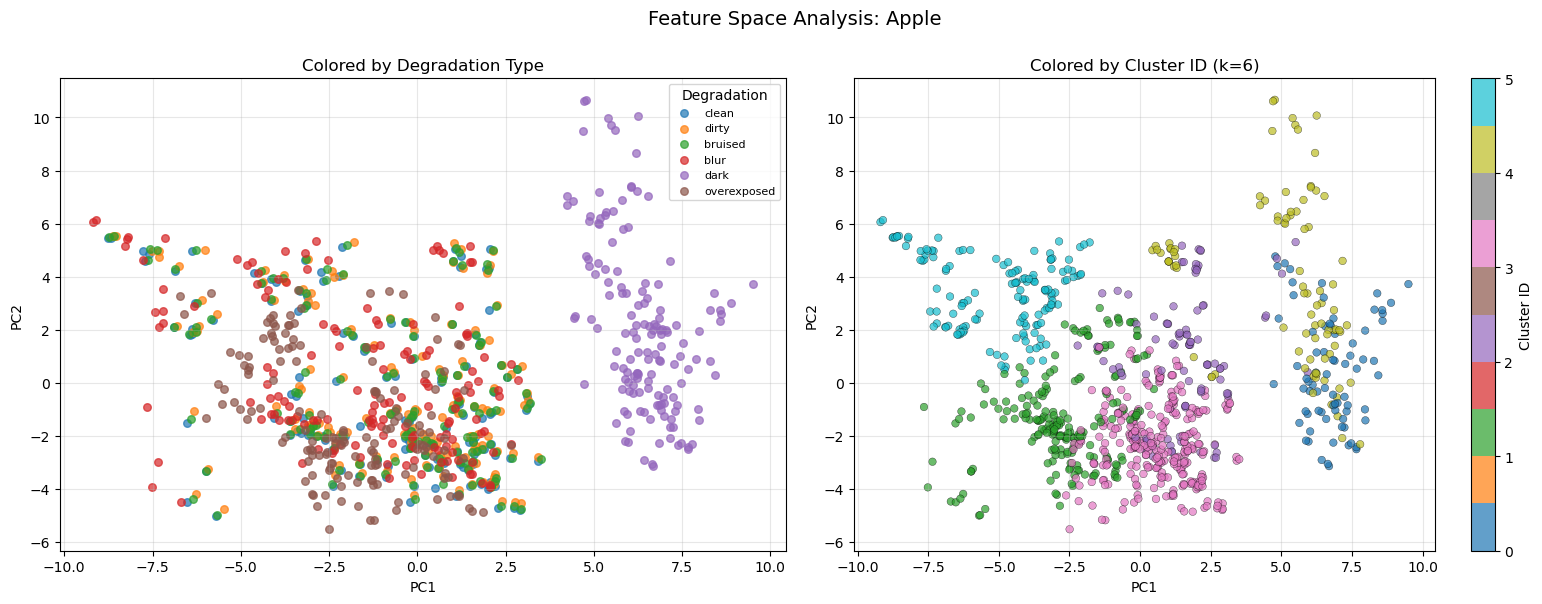

Saved report_assets/unsupervised_analysis/figures/fig_unsup_combined_banana.png


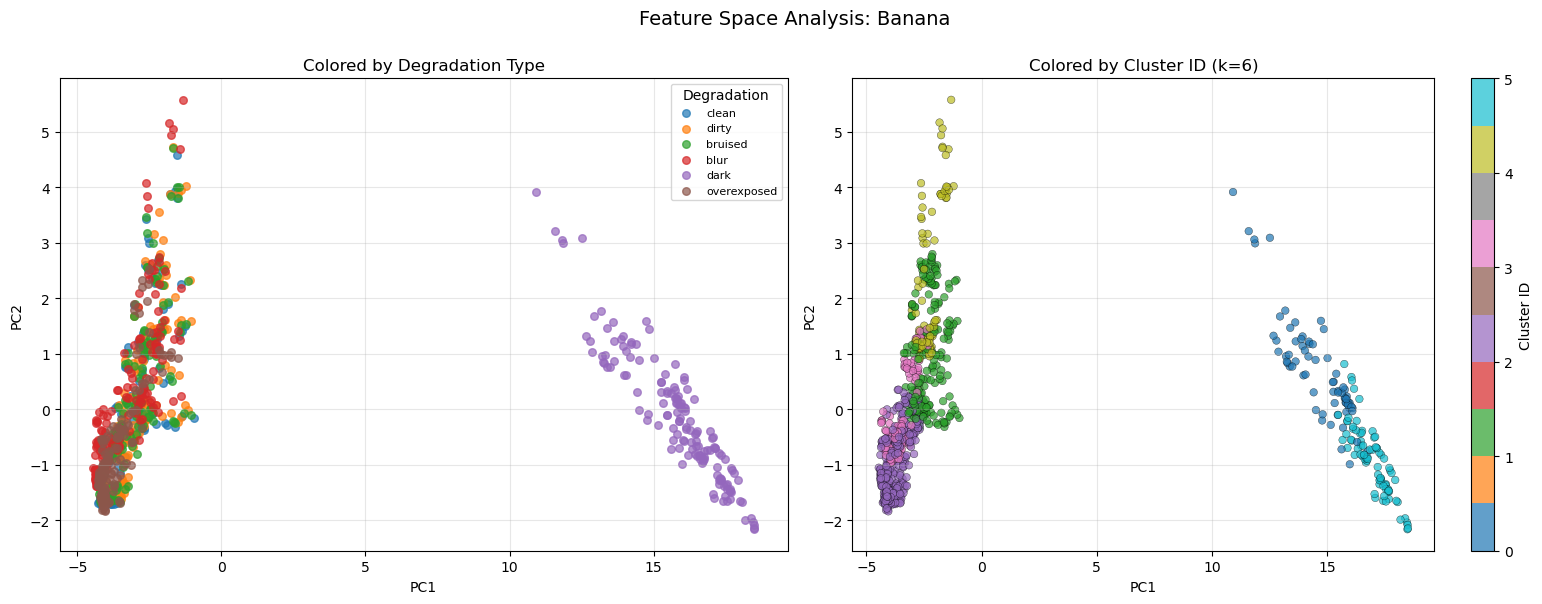

Saved report_assets/unsupervised_analysis/figures/fig_unsup_combined_lemon.png


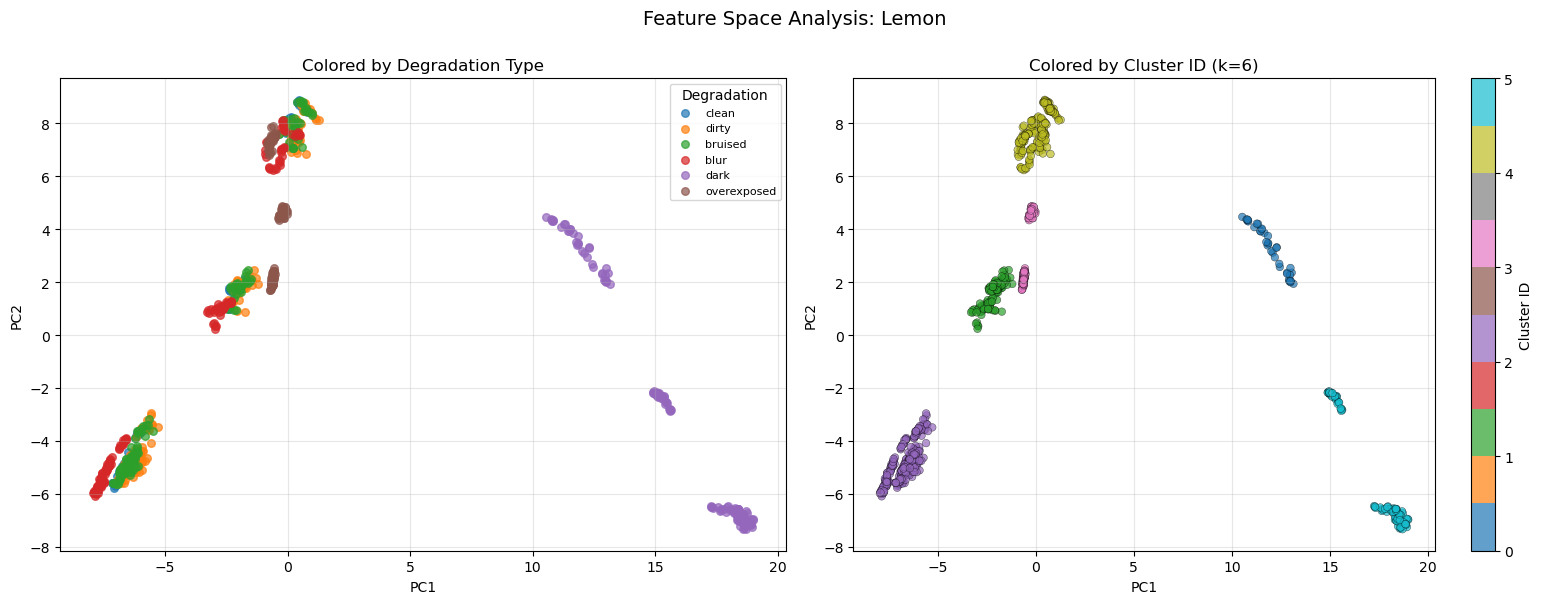

In [20]:
def plot_combined_degradation_cluster(class_name):
    class_data = [d for d in all_data if d["class_label"] == class_name]
    
    X = np.stack([d["features"] for d in class_data], axis=0)
    y_deg = np.array([d["deg_type"] for d in class_data])
    cluster_ids = kmeans_results[class_name]["cluster_ids"]
    
    pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
    X_2d = pca_2d.fit_transform(X)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    color_map = {
        "clean": "#1f77b4",
        "dirty": "#ff7f0e",
        "bruised": "#2ca02c",
        "blur": "#d62728",
        "dark": "#9467bd",
        "overexposed": "#8c564b",
    }
    
    for deg in DEGRADATIONS:
        idx = y_deg == deg
        axes[0].scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            label=deg,
            alpha=0.7,
            s=30,
            color=color_map.get(deg, "gray"),
        )
    
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")
    axes[0].set_title(f"Colored by Degradation Type")
    axes[0].legend(title="Degradation", loc="best", fontsize=8)
    axes[0].grid(alpha=0.3)
    
    scatter = axes[1].scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=cluster_ids,
        cmap="tab10",
        s=30,
        alpha=0.7,
        edgecolors="k",
        linewidth=0.3,
    )
    axes[1].set_xlabel("PC1")
    axes[1].set_ylabel("PC2")
    axes[1].set_title(f"Colored by Cluster ID (k={len(DEGRADATIONS)})")
    plt.colorbar(scatter, ax=axes[1], label="Cluster ID")
    axes[1].grid(alpha=0.3)
    
    fig.suptitle(f"Feature Space Analysis: {class_name}", fontsize=14, y=1.00)
    plt.tight_layout()
    filename = f"fig_unsup_combined_{class_name.lower()}.png"
    save_fig(filename)
    plt.show()

for cls in SELECTED_CLASSES:
    plot_combined_degradation_cluster(cls)

## 11. Cluster Composition Heatmaps

Saved report_assets/unsupervised_analysis/figures/fig_unsup_contingency_heatmap_apple.png


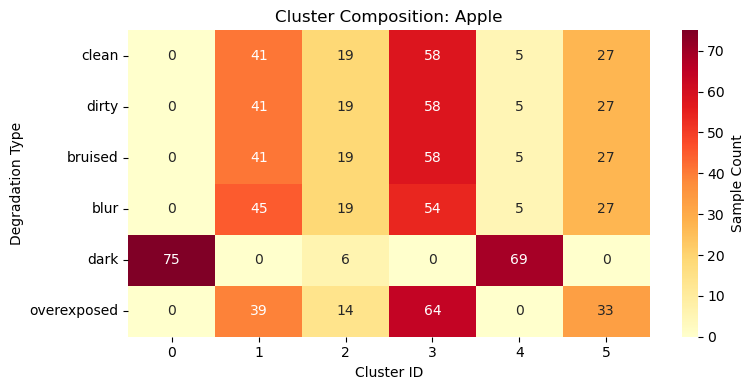

Saved report_assets/unsupervised_analysis/figures/fig_unsup_contingency_heatmap_banana.png


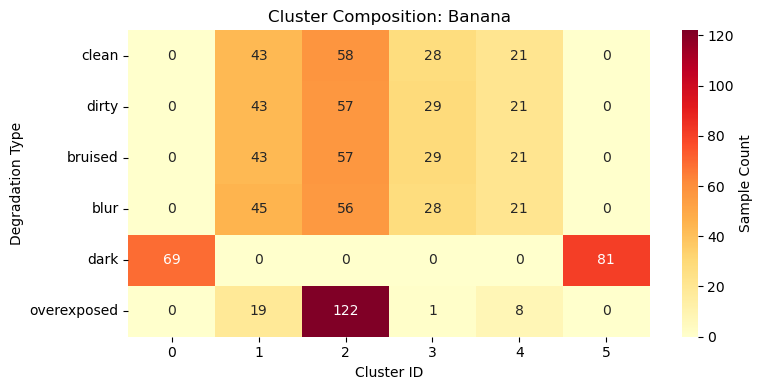

Saved report_assets/unsupervised_analysis/figures/fig_unsup_contingency_heatmap_lemon.png


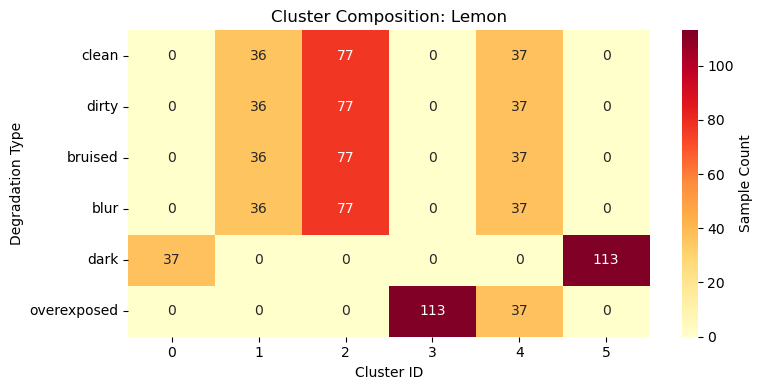

In [21]:
for cls in SELECTED_CLASSES:
    result = kmeans_results[cls]
    contingency = result["contingency"]
    
    data_for_heatmap = contingency[DEGRADATIONS].T
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(
        data_for_heatmap,
        annot=True,
        fmt="d",
        cmap="YlOrRd",
        cbar_kws={"label": "Sample Count"},
        ax=ax,
    )
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Degradation Type")
    ax.set_title(f"Cluster Composition: {cls}")
    plt.tight_layout()
    filename = f"fig_unsup_contingency_heatmap_{cls.lower()}.png"
    save_fig(filename)
    plt.show()

## 12. Key Insights Summary

In [19]:
insights = []

for cls in SELECTED_CLASSES:
    result = kmeans_results[cls]
    contingency = result["contingency"]
    silhouette = result["silhouette"]
    
    clean_samples = contingency.loc[contingency["clean"] > 0, "clean"].sum()
    contaminated_clusters = (contingency[contingency["clean"] > 0] != 0).sum(axis=1) > 1
    
    insights.append({
        "class": cls,
        "n_samples": len([d for d in all_data if d["class_label"] == cls]),
        "silhouette_score": f"{silhouette:.4f}",
        "clean_cluster_purity": f"{contingency[['dirty', 'bruised', 'blur', 'dark', 'overexposed']].sum().sum() / contingency.shape[0]:.2%}",
        "key_observation": "See heatmap and scatter plots above",
    })

insights_df = pd.DataFrame(insights)
save_table(insights_df, "table_unsup_03_insights_summary")
print("\nKey Insights Summary:")
print(insights_df)

Saved report_assets/unsupervised_analysis/tables/table_unsup_03_insights_summary.csv
Saved report_assets/unsupervised_analysis/tables/table_unsup_03_insights_summary.md

Key Insights Summary:
    class  n_samples silhouette_score clean_cluster_purity  \
0   Apple        900           0.1694            12500.00%   
1  Banana        900           0.2504            12500.00%   
2   Lemon        900           0.6657            12500.00%   

                       key_observation  
0  See heatmap and scatter plots above  
1  See heatmap and scatter plots above  
2  See heatmap and scatter plots above  


## Conclusion

This unsupervised analysis examines how different degradations scatter in the histogram-PCA feature space:

- **PCA 2D scatter plots** show whether degraded samples overlap with clean samples or form separate clusters.
- **t-SNE plots** provide an alternative (often clearer) visualization of neighborhood structure.
- **K-Means contingency tables** quantify how degradation types naturally separate (or mix) in the feature space.
- **Silhouette scores** measure the overall cluster quality (higher = more distinct degradation-specific regions).

**Interpretation**:
- High silhouette scores suggest that degradation types occupy well-separated regions, implying that robustness breaks depend on specific feature shifts.
- Low silhouette scores suggest extensive overlap, which may indicate that degradations partially fool the classifier through feature-space similarity to out-of-distribution exemplars.

The contingency tables directly show how much each degradation type "contaminates" its expected cluster, revealing whether dark/overexposed (expected to show large feature shifts) truly separate from clean, and whether gentle degradations (dirty/bruised) are feature-invariant.